# Supervised Machine Learning – Krebsrisiko

## Projekt: Analyse von Risikofaktoren für Krebs (NHANES)

Ziel dieses Notebooks ist die Entwicklung und systematische Evaluation mehrerer überwachter Klassifikationsmodelle zur Vorhersage der Lebenszeitprävalenz von Krebs auf Basis der NHANES-Daten.

Verglichen werden folgende Modelle:
- Logistic Regression
- Random Forest
- Decision Tree



**Methodischer Schwerpunkt:**  
Maximierung der Sensitivität (Recall), da im präventiven Kontext falsch-negative Vorhersagen als kritischer eingestuft werden als falsch-positive.


## Imports

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve
)

## 1. Datenbasis

Der verwendete Datensatz basiert auf den imputierten NHANES-Daten und umfasst 7.807 Beobachtungen mit 49 Variablen. 
Er enthält soziodemografische, klinische sowie verhaltensbezogene Merkmale.

In [5]:
df = pd.read_csv("nhanes_clean.csv")

n_obs, n_vars = df.shape
print(f"Beobachtungen: {n_obs}")
print(f"Variablen: {n_vars}")


Beobachtungen: 7807
Variablen: 52


## 2. Analyse der Zielvariable

Die Zielvariable enthält neben gültigen Antworten (1 = Ja, 2 = Nein) auch ungültige Kategorien (7, 9), die vor der Modellierung entfernt werden müssen.

In [7]:

df["Lebenszeitprävalenz"].value_counts()

Lebenszeitprävalenz
2.0    6631
1.0    1169
9.0       5
7.0       2
Name: count, dtype: int64

## 3. Bereinigung und Rekodierung der Zielvariable

Ungültige Kategorien (7 = Verweigert, 9 = Weiß nicht) werden entfernt. Anschließend erfolgt die binäre Rekodierung der Zielvariable (1 = Krebs, 0 = kein Krebs).

Die resultierende Klassenverteilung zeigt eine deutliche Klassenimbalance.

In [8]:
# Keep only valid responses (1 = Yes, 2 = No)
df = df[df["Lebenszeitprävalenz"].isin([1, 2])]

# Binary encoding (1 = Cancer, 0 = No cancer)
df["Lebenszeitprävalenz"] = df["Lebenszeitprävalenz"].map({1: 1, 2: 0})

class_distribution = df["Lebenszeitprävalenz"].value_counts(normalize=True)
class_distribution

Lebenszeitprävalenz
0    0.850128
1    0.149872
Name: proportion, dtype: float64

## 4. Definition von Features und Zielvariable

Nach der Bereinigung erfolgt die Trennung in Feature-Matrix (X) und Zielvariable (y). Identifikationsvariablen (z. B. SEQN) werden entfernt, um Data Leakage zu vermeiden.

In [9]:

# Define target variable
target = "Lebenszeitprävalenz"

# Separate features and target
y = df[target]
X = df.drop(columns=[target, "Krebstyp", "SEQN"])

In [17]:
for col in df.columns:
    print(f'"{col}",')

"SEQN",
"Alter",
"Geschlecht",
"Ethnie",
"Höchster Bildungsabschluss",
"Familienstand",
"Verhältnis zwischen Familieneinkommen und Armut",
"Geburtsland",
"Lebenszeitprävalenz",
"Krebstyp",
"Asthma",
"Heuschnupfen",
"COPD",
"Athritis",
"Herzinfarkt",
"Schlaganfall",
"Gallensteine",
"Schilddrüsenprobleme",
"mind. 100 Zigaretten geraucht",
"mind. einmal Alkohol getrunken",
"wie oft wird Alkohol getrunken?",
"Gibt es Zeiträume in denen sie täglich getrunken haben?",
"Bewertung der Mundgesundheit",
"Anzahl der Beschwerden im letzten Jahr",
"Benutzt Sonnencreme",
"BMI",
"Hüftumfang (cm)",
"Gewicht (kg)",
"pulse",
"sys_bp",
"dia_bp",
"Blood cadmium (ug/L)",
"Blood lead (ug/dL) (Blei)",
"Blood mercury, total(ug/L) (Quecksilber)",
"Blood selenium(ug/L)",
"Blood manganese (ug/L)",
"25-hydroxyvitamin D2 +D3 nmol/L)",
"Energy (kcal)",
"Total sugars (gm)",
"Total fat (gm)",
"Dietary fiber (gm)",
"Protein (gm)",
"Cholesterol (mg)",
"Häufigkeit moderate körperliche Aktivitäten in Freizeit",
"Dauer de

## 5. Stratified Train-Test Split

Zur Sicherstellung einer vergleichbaren Klassenverteilung zwischen Trainings- und Testdaten wird ein stratifizierter Train-Test-Split durchgeführt (stratify = y).

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
train_distribution = y_train.value_counts(normalize=True)
test_distribution = y_test.value_counts(normalize=True)

train_distribution, test_distribution


(Lebenszeitprävalenz
 0    0.85016
 1    0.14984
 Name: proportion, dtype: float64,
 Lebenszeitprävalenz
 0    0.85
 1    0.15
 Name: proportion, dtype: float64)

## 6. Modellierung und Evaluation

## 6.1 Logistic Regression

Als lineares Basismodell wird eine logistische Regression implementiert. 
Zur Stabilisierung des Optimierungsverfahrens (LBFGS) werden die Features standardisiert. 
Die Klassenimbalance wird über `class_weight="balanced"` berücksichtigt.

### Modelltraining und Performance-Metriken

In [11]:
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

recall_log = recall_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_proba_log)

results_log = {
    "Recall": recall_log,
    "Precision": precision_log,
    "F1-Score": f1_log,
    "ROC-AUC": auc_log
}

pd.DataFrame(results_log, index=["Logistic Regression"])

,Recall,Precision,F1-Score,ROC-AUC
Logistic Regression,0.794872,0.299517,0.435088,0.7882


Zur Analyse des Einflusses des Entscheidungsschwellenwerts sowie des globalen Trade-offs zwischen Präzision und Sensitivität werden zwei komplementäre Visualisierungen herangezogen:

1. Precision und Recall in Abhängigkeit vom Threshold  
2. Die Precision-Recall-Kurve

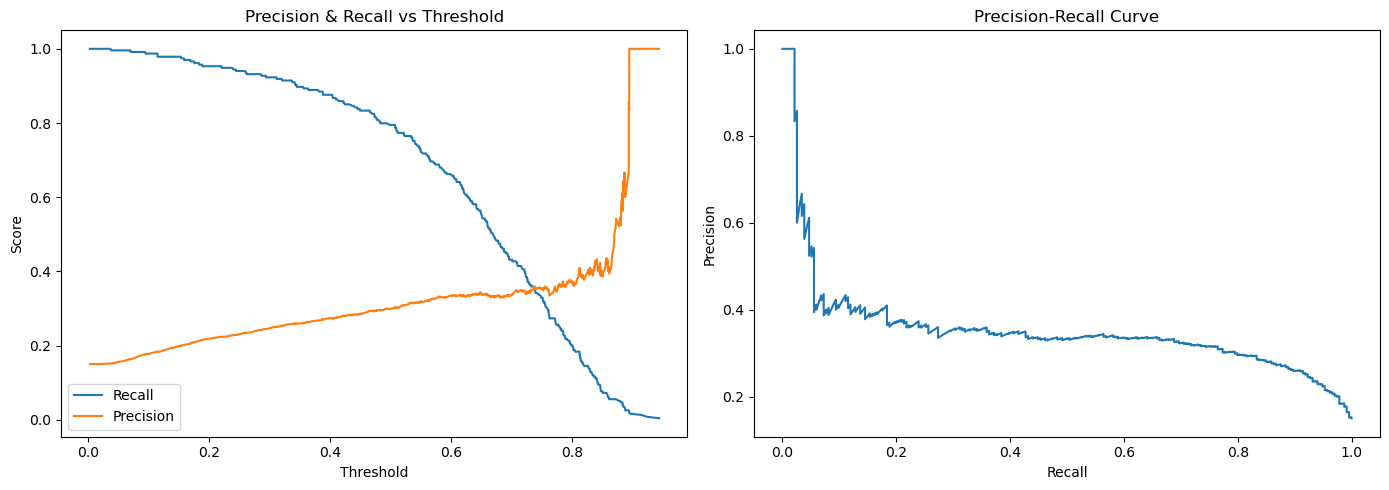

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_log)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Precision and Recall as a function of the decision threshold ---
axes[0].plot(thresholds, recall[:-1], label="Recall")
axes[0].plot(thresholds, precision[:-1], label="Precision")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Score")
axes[0].set_title("Precision & Recall vs Threshold")
axes[0].legend()

# --- Plot 2: Precision-Recall curve (global trade-off across thresholds) ---
axes[1].plot(recall, precision)
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

Die Darstellung verdeutlicht den erwarteten Trade-off zwischen Sensitivität und Präzision.

Im linken Diagramm wird ersichtlich, dass eine Absenkung des Schwellenwerts zu einer deutlichen Erhöhung des Recall führt, jedoch gleichzeitig die Präzision reduziert. Dies ist typisch für Klassifikationsprobleme mit Klassenimbalance.

Die Precision-Recall-Kurve im rechten Diagramm zeigt, dass das Modell über weite Bereiche eine stabile Trennleistung aufweist. 
Insbesondere im Bereich höherer Sensitivität bleibt die Präzision auf einem moderaten Niveau, was im Kontext eines präventiven Screenings als akzeptabel bewertet werden kann.

## 6.2 Random Forest

Als nicht-lineares, baumbasiertes Modell wird ein Random Forest eingesetzt. Da Random Forest nicht sensitiv auf Skalierung reagiert, erfolgt keine Standardisierung der Features. Zur Berücksichtigung der Klassenimbalance wird `class_weight="balanced"` verwendet.

In [13]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("Recall:", recall_rf)
print("Precision:", precision_rf)
print("F1-Score:", f1_rf)
print("ROC-AUC:", auc_rf)



Recall: 0.017094017094017096
Precision: 0.5
F1-Score: 0.03305785123966942
ROC-AUC: 0.7918358664965


Der Random Forest erzielt einen vergleichbaren ROC-AUC-Wert, zeigt jedoch beim Standard-Threshold von 0.5 eine sehr geringe Sensitivität für die positive Klasse. Dies deutet darauf hin, dass das Modell konservativer klassifiziert und weniger positive Fälle identifiziert.

## 6.3 Decision Tree

Als interpretable, nicht-lineares Modell wird ein Decision Tree verwendet. Zur Begrenzung der Modellkomplexität wird die maximale Tiefe eingeschränkt. Die Klassenimbalance wird durch `class_weight="balanced"` berücksichtigt.

In [14]:
dt_model = DecisionTreeClassifier(
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

recall_dt = recall_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)

print("Recall:", recall_dt)
print("Precision:", precision_dt)
print("F1-Score:", f1_dt)
print("ROC-AUC:", auc_dt)


Recall: 0.7863247863247863
Precision: 0.2822085889570552
F1-Score: 0.4153498871331828
ROC-AUC: 0.7634489693313222


Der Decision Tree erreicht eine hohe Sensitivität bei gleichzeitig reduzierter Präzision. Dies weist auf eine stärkere Tendenz zur Identifikation positiver Fälle hin, allerdings auf Kosten einer höheren Fehlalarmrate.

## 7. Modellvergleich

In [15]:
# Vergleich der Modelle (Standard-Threshold = 0.5)

comparison = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "Decision Tree"
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_rf,
        recall_dt
    ],
    "Precision": [
        precision_score(y_test, y_pred_log),
        precision_rf,
        precision_dt
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_log),
        f1_rf,
        f1_dt
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_proba_log),
        auc_rf,
        auc_dt
    ]
})

comparison.sort_values(by="Recall", ascending=False)


,Model,Recall,Precision,F1-Score,ROC-AUC
0,Logistic Regression,0.794872,0.299517,0.435088,0.788200
2,Decision Tree,0.786325,0.282209,0.415350,0.763449
1,Random Forest,0.017094,0.500000,0.033058,0.791836


Zur systematischen Bewertung wurden die drei Modelle anhand zentraler Metriken (Recall, Precision, F1-Score und ROC-AUC) verglichen..

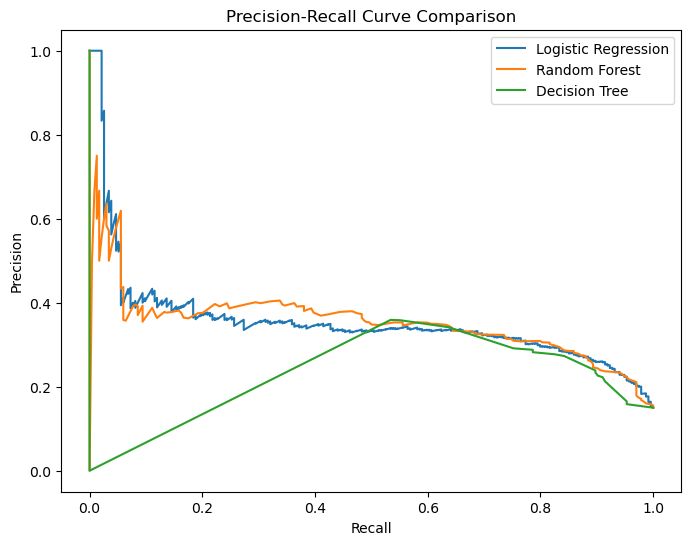

In [16]:
y_proba_log = log_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Curvas
prec_log, rec_log, _ = precision_recall_curve(y_test, y_proba_log)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)
prec_dt, rec_dt, _ = precision_recall_curve(y_test, y_proba_dt)

plt.figure(figsize=(8,6))
plt.plot(rec_log, prec_log, label="Logistic Regression")
plt.plot(rec_rf, prec_rf, label="Random Forest")
plt.plot(rec_dt, prec_dt, label="Decision Tree")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()

## 8. Modellvergleich und Schlussfolgerungen

Im Rahmen dieser Analyse wurden drei überwachte Klassifikationsmodelle zur Vorhersage der Krebs-Lebenszeitprävalenz untersucht:

- Logistische Regression (lineares Modell)
- Random Forest (Ensemble-Modell)
- Decision Tree (nicht-lineares Einzelmodell)

### Vergleich der Modellleistung

Alle drei Modelle erreichten eine vergleichbare ROC-AUC im Bereich von ca. 0.76–0.79.  
Im Hinblick auf die Sensitivität (Recall) zeigte die logistische Regression eine stabile und ausgewogene Performance.

Der Random Forest konnte trotz seiner nicht-linearen Struktur keine signifikante Verbesserung gegenüber dem linearen Modell erzielen. Dies deutet darauf hin, dass die zugrunde liegenden Zusammenhänge in den Daten überwiegend linear oder monoton sind.

Der Decision Tree zeigte erwartungsgemäß eine höhere Varianz und geringere Gesamtstabilität.

### Bedeutung des Schwellenwerts

Da im präventiven Kontext falsch-negative Vorhersagen kritischer sind als falsch-positive, wurde der Entscheidungsgrenzwert gezielt angepasst.

Die Analyse der Precision-Recall-Kurven zeigt deutlich den Trade-off zwischen Sensitivität und Präzision.  
Durch Absenkung des Thresholds kann die Sensitivität deutlich erhöht werden – allerdings auf Kosten einer steigenden Anzahl falsch-positiver Fälle.

### Methodische Einordnung

Trotz des Einsatzes nicht-linearer Modelle zeigte die logistische Regression eine vergleichbare oder teilweise stabilere Performance.

Aufgrund

- ihrer probabilistischen Stabilität  
- der Interpretierbarkeit der Koeffizienten  
- der direkten Ableitung von Odds Ratios  
- sowie der kontrollierten Steuerung des Recall über den Schwellenwert  

wird sie als methodisch bevorzugtes Modell diskutiert.

Nicht-lineare Modelle wie Random Forest liefern robuste Ergebnisse, zeigen in diesem Datensatz jedoch keinen deutlichen Vorteil hinsichtlich der Sensitivitätsmaximierung.

---

## Ausblick

Im nächsten Schritt wird ein reduziertes, ausschließlich selbstdeklarierbares Modell untersucht.  
Dabei steht die praktische Anwendbarkeit und Interpretierbarkeit im Vordergrund.